### Turing.ml example: https://turing.ml/dev/tutorials/10-bayesian-differential-equations/ 

In [ ]:
using Turing, Distributions, DifferentialEquations

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(14);

In [ ]:
function lotka_volterra(du,u,p,t)
    x, y = u
    α, β, γ, δ  = p
    du[1] = (α - β*y)x # dx =
    du[2] = (δ*x - γ)y # dy =
end
p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0,1.0]
prob1 = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
sol = solve(prob1,Tsit5())
plot(sol)

sol1 = solve(prob1,Tsit5(),saveat=0.1)
odedata = Array(sol1) + 0.8 * randn(size(Array(sol1)))
plot(sol1, alpha = 0.3, legend = false); scatter!(sol1.t, odedata')

In [ ]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data, prob1)
    σ ~ InverseGamma(2, 3) # ~ is the tilde character
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)

    p = [α,β,γ,δ]
    prob = remake(prob1, p=p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitlv(odedata, prob1)

# This next command runs 3 independent chains without using multithreading.
chain = mapreduce(c -> sample(model, NUTS(.65),1000), chainscat, 1:3)
plot(chain)

In [ ]:
pl = scatter(sol1.t, odedata');
chain_array = Array(chain)
for k in 1:300
    resol = solve(remake(prob1,p=chain_array[rand(1:1500), 1:4]),Tsit5(),saveat=0.1)
    plot!(resol, alpha=0.1, color = "#BBBBBB", legend = false)
end
# display(pl)
plot!(sol1, w=1, legend = false)

# troubleshooting transporter model



In [ ]:
using Catalyst, DifferentialEquations, StatsPlots, Plots, DataFrames, CSV, Random, Turing, Latexify, ModelingToolkit, DynamicHMC
using ModelingToolkit: varmap_to_vars
using Optim, Noise, AdvancedMH, MCMCChains, StatsBase, Sundials
using BenchmarkTools

function gen_∂logπ∂θ(vi, spl, model)
    function ∂logπ∂θ(x)
        return Turing.Core.gradient_logp(x, vi, model, spl)
    end
    return ∂logπ∂θ
end

function test_gradient(model)
    var_info = Turing.VarInfo(model)
    ctx = Turing.DefaultContext()

    spl = DynamicPPL.Sampler(NUTS(.65))
    DynamicPPL.link!(var_info, spl)

    ∂logπ∂θ = gen_∂logπ∂θ(var_info, spl, model)
    return ∂logπ∂θ, var_info[spl]
end


# Normal log-likelihood calculation
function calc_norm_log_likelihood(mu,sigma,X)
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = length(X)
    f1 = -1*(n/2)*log(2*pi*sigma^2)
    f2_a = -1/(2*sigma^2)
    f2_b = 0 
    for i in 1:n
        f2_b += (X[i]-mu[i])^2
    end
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
end

# flux calculation function
function calc_flux(p,u,v)
    flux_in = v*(p[1]*u[1])
    flux_out = v*(p[2]*u[2].*u[3])
    net_flux = flux_in - flux_out         
end

Random.seed!(14)
sigma_f = 1
t_short = false

# define reaction network in Catalyst
rn = @reaction_network begin
  (k1_f*H_out, k1_r), OF <--> OF_Hb
  (k2_f, k2_r), OF_Hb <--> IF_Hb
  (k3_f, k3_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k4_f, k4_r), IF_Hb_Sb <--> IF_Sb + H_in
  (k5_f, k5_r), IF_Sb <--> OF_Sb
  (k6_f, k6_r*S_out), OF_Sb <--> OF
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r

# convert reaction network to ODEsystem
odesys = convert(ODESystem, rn)

# define initial variable values and parameters
H_out_ref = 1e-7
S_out_ref = 1e-3
stdev_ref = sigma_f*1e-13
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r stdev_s
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) IF_Hb(t) IF_Hb_Sb(t) IF_Sb(t) OF_Sb(t)
u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, OF_Hb => 2.833e-8,  
        IF_Hb => 2.833e-8, IF_Hb_Sb => 2.833e-8,
        IF_Sb => 2.125e-8, OF_Sb => 2.125e-8, 
        ]
pmap = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

# create ODEproblem w/ timed events discrete callback
if t_short == true
    t_sample = 0.4
else
    t_sample = 0.04
end    
tspan1 = (0.0,15)
oprob = ODEProblem(odesys, u0map, tspan1, pmap)
event_times = [5.0,10.0]
condition(u,t,integrator) = t ∈ event_times
function affect!(integrator)
    if integrator.t == 5.0
        integrator.p[1] = 5e-8
    elseif integrator.t == 10.0
        integrator.p[1] = 1e-7
    end
end
cb = DiscreteCallback(condition,save_positions=(false, false), affect!)

atol=1e-18
rtol=1e-15

# get y_true and y_obs
# s_true = solve(oprob, CVODE_BDF(), abstol = 1e-18, reltol = 1e-12, saveat=t_sample, callback=cb, tstops=event_times)
s_true = solve(oprob, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
@btime solve(oprob,TRBDF2(),abstol = atol,  reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times) 
@btime solve(oprob,RadauIIA5(),abstol = atol,  reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times) 
@btime solve(oprob, KenCarp4(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times) 
@btime solve(oprob,CVODE_BDF(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times) 


k_true = [pmap[9][2], pmap[10][2]]
c_true = [s_true[IF_Hb_Sb], s_true[H_in], s_true[IF_Sb]]
vol = 0.0001
y_true = calc_flux(k_true,c_true,vol)


# y_obs = add_gauss(y_true,stdev_ref)
# df = DataFrame(data = y_obs)
# CSV.write("data_grid_test3.csv", df)
df2 = CSV.read("data_grid_test3.csv", DataFrame)
y_obs = df2[!, "data"]

ref_log_likelihood = calc_norm_log_likelihood(y_obs,stdev_ref,y_true)

println(length(y_obs))
println(ref_log_likelihood)


##### sampling
println("sampling...")
# create Turing model w/ forward differentiation
Turing.setadbackend(:forwarddiff)
@model function rxn_sampler(data, prob, sys)
    
    
    log_stdev_sample2 ~ Uniform(log10(5e-14), log10(5e-13))
    
    log_k1_f ~ Uniform(6,12) # log10 rate constant (ref=1e10)
    log_k1_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3)  
    
    log_k2_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k2_r ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    
    log_k3_f ~ Uniform(3,9)  # log10 rate constant (ref=1e7) 
    log_k3_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    
    log_k4_f ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_r ~ Uniform(6,12)  # log10 rate constant (ref=1e10)
    
    log_k5_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k5_r ~ Uniform(-2,4)   # log10 rate constant (ref=1e2)
    
    log_k6_f ~ Uniform(-1,5)  # log10  rate constant (ref=1e3)
    
    # set parameter values and initial concentrations
    log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r) 
    pmap2 = [H_out => H_out_ref, S_out => S_out_ref,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
    ]
    
    # solve ODE system
    pnew2 = varmap_to_vars(pmap2, parameters(sys))
    oprob2 = remake(prob, p=pnew2)
    #sol2 = solve(oprob2, TRBDF2(), abstol = 1e-18, reltol = 1e-12, saveat=0.04, callback=cb, tstops=event_times)
    sol2 = solve(oprob2, TRBDF2(), abstol = atol, reltol = rtol, saveat=0.04, callback=cb, tstops=event_times)
    
    # calc flux (y_pred)
    k2 = [pmap2[9][2], pmap2[10][2]]
    c2 = [sol2[IF_Hb_Sb], sol2[H_in], sol2[IF_Sb]]
    vol = 0.0001
    y_pred2 = calc_flux(k2,c2,vol)
    
    for i = 1:length(data)
        data[i] ~ Normal(y_pred2[i], 10^log_stdev_sample2)
    end
end

model = rxn_sampler(y_obs, oprob, odesys)

c =sample(model, NUTS(.65),1000)

# #model = fit(...)
# ∇, vi = test_gradient(model);
# ∇(vi)


# # Use NelderMead
# mle_estimate1 = optimize(model, MLE(), NelderMead(), Optim.Options(iterations = 10_000, allow_f_increases=true, g_tol=atol))

# # Use SimulatedAnnealing
# mle_estimate2 = optimize(model, MLE(), SimulatedAnnealing(), Optim.Options(iterations = 10_000, allow_f_increases=true, g_tol=atol))

# # Use ParticleSwarm
# mle_estimate3 = optimize(model, MLE(), ParticleSwarm(), Optim.Options(iterations = 10_000, allow_f_increases=true, g_tol=atol))

# # Use Newton
# #mle_estimate4 = optimize(model, MLE(), Newton())

# # Use AcceleratedGradientDescent
# mle_estimate5 = optimize(model, MLE(), AcceleratedGradientDescent(), Optim.Options(iterations = 10_000, allow_f_increases=true, g_tol=atol))

# println(mle_estimate1.values.array)
# println(mle_estimate2.values.array)
# println(mle_estimate3.values.array)
# #println(mle_estimate4.values.array)
# println(mle_estimate5.values.array)

In [ ]:
plot(y_true, ylim=(-1.5e-11, 1.5e-11));scatter!(y_obs, alpha=0.25)

In [ ]:
using Pathfinder

iter=1_000

# Use NelderMead
#mle_estimate1 = optimize(model, MLE(), NelderMead(), Optim.Options(iterations = iter, allow_f_increases=true, g_tol=atol))


# # Use SimulatedAnnealing
# mle_estimate2 = optimize(model, MLE(), SimulatedAnnealing(), Optim.Options(iterations = iter, allow_f_increases=true, g_tol=atol))

# # Use ParticleSwarm
# mle_estimate3 = optimize(model, MLE(), ParticleSwarm(), Optim.Options(iterations = iter, allow_f_increases=true, g_tol=atol))

# # Use Newton
# #mle_estimate4 = optimize(model, MLE(), Newton())

# # Use AcceleratedGradientDescent
# mle_estimate5 = optimize(model, MLE(), AcceleratedGradientDescent(), Optim.Options(iterations = iter, allow_f_increases=true, g_tol=atol))

#println(mle_estimate1.values.array)
# println(mle_estimate2.values.array)
# println(mle_estimate3.values.array)
# #println(mle_estimate4.values.array)
# println(mle_estimate5.values.array)


result_multi = multipathfinder(model, 1_000; nruns=10)

In [ ]:
result_multi.draws_transformed

In [ ]:
using AdvancedHMC, Distributions, ForwardDiff
using LinearAlgebra, Plots

# Choose parameter dimensionality and initial parameter value
D = 12; initial_θ = rand(D)

# Define the target distribution
ℓπ(θ) = logpdf(MvNormal(zeros(D), I), θ)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 2_000, 1_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(D)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true)


### advancedHMC using ODEs

In [ ]:
using AdvancedHMC, Distributions, ForwardDiff
using LinearAlgebra

# Choose parameter dimensionality and initial parameter value
D = 10; initial_θ = rand(D)

# Define the target distribution
ℓπ(θ) = logpdf(MvNormal(zeros(D), I), θ)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 2_000, 1_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(D)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true)

#### sampling

In [ ]:
using DiffEqFlux, DifferentialEquations, Plots, AdvancedHMC, MCMCChains
using JLD, StatsPlots

u0 = [2.0; 0.0]
datasize = 40
tspan = (0.0, 1)
tsteps = range(tspan[1], tspan[2], length = datasize)

function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob_trueode, Tsit5(), saveat = tsteps))


dudt2 = FastChain((x, p) -> x.^3,
                  FastDense(2, 50, tanh),
                  FastDense(50, 2))
prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(), saveat = tsteps)

function predict_neuralode(p)
    Array(prob_neuralode(u0, p))
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

l(θ) = -sum(abs2, ode_data .- predict_neuralode(θ)) - sum(θ .* θ)


function dldθ(θ)
    x,lambda = Flux.Zygote.pullback(l,θ)
    grad = first(lambda(1))
    return x, grad
end

metric  = DiagEuclideanMetric(length(prob_neuralode.p))

h = Hamiltonian(metric, l, dldθ)


integrator = Leapfrog(find_good_stepsize(h, Float64.(prob_neuralode.p)))


prop = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)

adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.45, integrator))

samples, stats = sample(h, prop, Float64.(prob_neuralode.p), 500, adaptor, 500; progress=true)


losses = map(x-> x[1],[loss_neuralode(samples[i]) for i in 1:length(samples)])

##################### PLOTS: LOSSES ###############
scatter(losses, ylabel = "Loss",  yscale= :log, label = "Architecture1: 500 warmup, 500 sample")

################### RETRODICTED PLOTS: TIME SERIES #################
pl = scatter(tsteps, ode_data[1,:], color = :red, label = "Data: Var1", xlabel = "t", title = "Spiral Neural ODE")
scatter!(tsteps, ode_data[2,:], color = :blue, label = "Data: Var2")

for k in 1:300
    resol = predict_neuralode(samples[100:end][rand(1:400)])
    plot!(tsteps,resol[1,:], alpha=0.04, color = :red, label = "")
    plot!(tsteps,resol[2,:], alpha=0.04, color = :blue, label = "")
end

idx = findmin(losses)[2]
prediction = predict_neuralode(samples[idx])

plot!(tsteps,prediction[1,:], color = :black, w = 2, label = "")
plot!(tsteps,prediction[2,:], color = :black, w = 2, label = "Best fit prediction", ylims = (-2.5, 3.5))



#################### RETRODICTED PLOTS - CONTOUR ####################
pl = scatter(ode_data[1,:], ode_data[2,:], color = :red, label = "Data",  xlabel = "Var1", ylabel = "Var2", title = "Spiral Neural ODE")

for k in 1:300
    resol = predict_neuralode(samples[100:end][rand(1:400)])
    plot!(resol[1,:],resol[2,:], alpha=0.04, color = :red, label = "")
end

plot!(prediction[1,:], prediction[2,:], color = :black, w = 2, label = "Best fit prediction", ylims = (-2.5, 3))


# 5/22/2022

### import packages, define functions, and create reaction model 

In [4]:
using Catalyst, DifferentialEquations, StatsPlots, Plots, DataFrames, CSV, Random, Latexify, ModelingToolkit, DynamicHMC
using ModelingToolkit: varmap_to_vars
using Optim, Noise, AdvancedMH, MCMCChains, StatsBase, Sundials
using BenchmarkTools
using AdvancedHMC, Distributions, ForwardDiff
using LinearAlgebra, Plots, Pathfinder, Turing


# Normal log-likelihood calculation
function calc_norm_log_likelihood(mu,sigma,X)
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = length(X)
    f1 = -1*(n/2)*log(2*pi*sigma^2)
    f2_a = -1/(2*sigma^2)
    f2_b = 0 
    for i in 1:n
        f2_b += (X[i]-mu[i])^2
    end
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
end


# flux calculation function
function calc_flux(p,u,v)
    flux_in = v*(p[1]*u[1])
    flux_out = v*(p[2]*u[2].*u[3])
    net_flux = flux_in - flux_out
    net_flux_trim = net_flux[2:end]
end


# define reaction network in Catalyst
rn = @reaction_network begin
  (k1_f*H_out, k1_r), OF <--> OF_Hb
  (k2_f, k2_r), OF_Hb <--> IF_Hb
  (k3_f, k3_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k4_f, k4_r), IF_Hb_Sb <--> IF_Sb + H_in
  (k5_f, k5_r), IF_Sb <--> OF_Sb
  (k6_f, k6_r*S_out), OF_Sb <--> OF
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r

# convert reaction network to ODEsystem
odesys = convert(ODESystem, rn)

Model ##ReactionSystem#316 with 8 equations
States (8):
  OF(t)
  OF_Hb(t)
  IF_Hb(t)
  S_in(t)
  IF_Hb_Sb(t)
  IF_Sb(t)
⋮
Parameters (14):
  H_out
  S_out
  k1_f
  k1_r
  k2_f
  k2_r
⋮

### generate synthetic data and calculate steady state populations

synthetic model settings:
  sigma=1.0e-13
  parameter values (steady state)=Pair{Num, Float64}[H_out => 5.0e-8, S_out => 0.001, k1_f => 1.0e10, k1_r => 1000.0, k2_f => 100.0, k2_r => 100.0, k3_f => 1.0e7, k3_r => 1000.0, k4_f => 1000.0, k4_r => 1.0e10, k5_f => 100.0, k5_r => 100.0, k6_f => 1000.0, k6_r => 1.0e7]
  initial populations (steady state)=Pair{Num, Float64}[H_in(t) => 1.0000006654560167e-7, S_in(t) => 0.000999981111790563, OF(t) => 4.721819523811756e-9, OF_Hb(t) => 4.721827051893435e-9, IF_Hb(t) => 4.721902739690265e-9, IF_Hb_Sb(t) => 4.721814289120632e-8, IF_Sb(t) => 4.721812001753802e-8, OF_Sb(t) => 4.7218187775823155e-8]

ODE settings:
  atol=1.0e-18
  rtol=1.0e-15
  sample rate=1 sample / 0.04 seconds
  t span=(0.0, 4.0)
  t events=[2.0]

synthetic data settings:
  random seed=14
  n data points=100
  reference log likelihood: 2851.713582722496



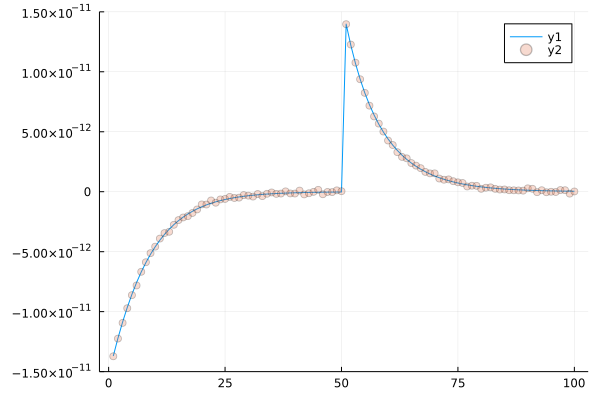

In [5]:
# set buffer solution concentrations, sigma ref, ODE sample rate, ODE tspan, ODE tolerance, random seed
H_out_ref = 1e-7
S_out_ref = 1e-3
H_out_activation = 5e-8
S_out_activation = 1e-3
stdev_ref = 1e-13
t_sample = 0.04    
tspan1 = (0.0,4.0)
atol=1e-18
rtol=1e-15
seed = 14
Random.seed!(seed)

# define initial variable values and parameters
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r stdev_s
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) IF_Hb(t) IF_Hb_Sb(t) IF_Sb(t) OF_Sb(t)
u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, OF_Hb => 2.833e-8,  
        IF_Hb => 2.833e-8, IF_Hb_Sb => 2.833e-8,
        IF_Sb => 2.125e-8, OF_Sb => 2.125e-8, 
        ]
pmap = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

# get steady state populations
oprob = ODEProblem(odesys, u0map, tspan1, pmap,)
sol_ss = solve(oprob, DynamicSS(TRBDF2(), atol, rtol))

# update initial populations and parameter values
u0map_ss = [H_in => sol_ss[H_in][end], S_in => sol_ss[S_in][end], 
        OF => sol_ss[OF][end], OF_Hb => sol_ss[OF_Hb][end],  
        IF_Hb => sol_ss[IF_Hb][end], IF_Hb_Sb => sol_ss[IF_Hb_Sb][end],
        IF_Sb => sol_ss[IF_Sb][end], OF_Sb => sol_ss[OF_Sb][end], 
        ]

pmap_ss = [H_out => H_out_activation, S_out => S_out_activation,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

# create discrete callback (timed events) and solve ODE problem
event_times = [2.0]
condition(u,t,integrator) = t ∈ event_times
function affect!(integrator)
    if integrator.t == 2.0
        integrator.p[1] = 1e-7
    end
end
cb = DiscreteCallback(condition,save_positions=(false, false), affect!)
oprob_ss = ODEProblem(odesys, u0map_ss, tspan1, pmap_ss,)

# get y_true and y_obs
s_true = solve(oprob_ss, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
k_true = [pmap_ss[9][2], pmap_ss[10][2]]
c_true = [s_true[IF_Hb_Sb], s_true[H_in], s_true[IF_Sb]]
vol = 0.0001
y_true = calc_flux(k_true,c_true,vol)
y_obs = add_gauss(y_true,stdev_ref)
# # df = DataFrame(data = y_obs)
# # CSV.write("data_grid_test3.csv", df)
# df2 = CSV.read("data_grid_test3.csv", DataFrame)
# y_obs = df2[!, "data"]
ref_log_likelihood = calc_norm_log_likelihood(y_obs,stdev_ref,y_true)
n_data = length(y_obs)

# print out summary
println("synthetic model settings:")
println("  sigma=$stdev_ref")
println("  parameter values (steady state)=$pmap_ss")
println("  initial populations (steady state)=$u0map_ss")
println()
println("ODE settings:")
println("  atol=$atol")
println("  rtol=$rtol")
println("  sample rate=1 sample / $t_sample seconds")
println("  t span=$tspan1")
println("  t events=$event_times")
println()
println("synthetic data settings:")
println("  random seed=$seed")
println("  n data points=$n_data")
println("  reference log likelihood: $ref_log_likelihood")
println()
plot(y_true, ylim=(-1.5e-11, 1.5e-11));scatter!(y_obs, alpha=0.25)


### Turing model and get Pathfinder results (MCMC initialization)

In [ ]:
Turing.setadbackend(:forwarddiff)
@model function rxn_sampler(data, prob, sys)
    
    #log_stdev_sample2 ~ Uniform(log10(5e-14), log10(5e-13))
    log_stdev_sample2  ~ Uniform(log10(5e-14), log10(5e-13))
    
    log_k1_f ~ Uniform(6,12) # log10 rate constant (ref=1e10)
    log_k1_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3)  
    
    log_k2_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k2_r ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    
    log_k3_f ~ Uniform(3,9)  # log10 rate constant (ref=1e7) 
    log_k3_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    
    log_k4_f ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_r ~ Uniform(6,12)  # log10 rate constant (ref=1e10)
    
    log_k5_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k5_r ~ Uniform(-2,4)   # log10 rate constant (ref=1e2)
    
    log_k6_f ~ Uniform(-1,5)  # log10  rate constant (ref=1e3)
    log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r) 
    
    # set parameter values and initial concentrations
    pmap2 = [H_out => H_out_activation, S_out => S_out_activation,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
    ]
    
    # solve ODE system
    pnew2 = varmap_to_vars(pmap2, parameters(sys))
    oprob2 = remake(prob, p=pnew2)
    sol2 = solve(oprob2, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
    
    # calc flux (y_pred)
    k2 = [pmap2[9][2], pmap2[10][2]]
    c2 = [sol2[IF_Hb_Sb], sol2[H_in], sol2[IF_Sb]]
    vol = 0.0001
    y_pred2 = calc_flux(k2,c2,vol)
    
    for i = 1:length(data)
        #data[i] ~ Normal(y_pred2[i], 10^log_stdev_sample2)
        data[i] ~ Normal(y_pred2[i], 10^log_stdev_sample2)
    end
end

model = rxn_sampler(y_obs, oprob_ss, odesys)



c = sample(model, Turing.NUTS(1000, .45, max_depth=100),1000);
plot(c)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/georgeau/.julia/packages/AdvancedHMC/w90s5/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/georgeau/.julia/packages/AdvancedHMC/w90s5/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/georgeau/.julia/packages/AdvancedHMC/w90s5/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/georgeau/.julia/packages/Turing/rl6ku/src/inference/hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/georgeau/.julia/packages/Advan

In [ ]:
result_multi = multipathfinder(model, 1_000; nruns=10)

### AdvancedHMC

In [ ]:

function log_prior(p)
    return 0
end


function log_likelihood(p)
    #log_stdev_sample2 ~ Uniform(log10(5e-14), log10(5e-13))
    log_stdev_sample2 = p[1]
    
    log_k1_f = p[2]
    log_k1_r = p[3]
    
    log_k2_f = p[4]
    log_k2_r = p[5]
    
    log_k3_f = p[6]
    log_k3_r = p[7]
    
    log_k4_f = p[8]
    log_k4_r = p[9]
    
    log_k5_f = p[10]
    log_k5_r = p[11]
    
    log_k6_f = p[12]
    log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r) 
    
    # set parameter values and initial concentrations
    pmap2 = [H_out => H_out_activation, S_out => S_out_activation,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
    ]
    
    # solve ODE system
    pnew2 = varmap_to_vars(pmap2, parameters(odesys))
    oprob2 = remake(oprob_ss, p=pnew2)
    sol2 = solve(oprob2, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
    
    # calc flux (y_pred)
    k2 = [pmap2[9][2], pmap2[10][2]]
    c2 = [sol2[IF_Hb_Sb], sol2[H_in], sol2[IF_Sb]]
    vol = 0.0001
    y_pred2 = calc_flux(k2,c2,vol)
    log_like = calc_norm_log_likelihood(y_pred2,10^log_stdev_sample2, y_obs)
    return log_like
end
    

function log_posterior(p)
    return log_likelihood(p) + log_prior(p)
end


function get_p0()
    log_stdev_sample2  =rand(Uniform(log10(5e-14), log10(5e-13)))   
    log_k1_f =rand(Uniform(6,12)) # log10 rate constant (ref=1e10)
    log_k1_r =rand(Uniform(-1,5))  # log10 rate constant (ref=1e3)    
    log_k2_f =rand(Uniform(-2,4))  # log10 rate constant (ref=1e2)
    log_k2_r =rand(Uniform(-2,4))  # log10 rate constant (ref=1e2)  
    log_k3_f =rand(Uniform(3,9))  # log10 rate constant (ref=1e7) 
    log_k3_r =rand(Uniform(-1,5))  # log10 rate constant (ref=1e3)   
    log_k4_f =rand(Uniform(-1,5))  # log10 rate constant (ref=1e3) 
    log_k4_r =rand(Uniform(6,12))  # log10 rate constant (ref=1e10)
    log_k5_f =rand(Uniform(-2,4))  # log10 rate constant (ref=1e2)
    log_k5_r =rand(Uniform(-2,4))   # log10 rate constant (ref=1e2)
    log_k6_f =rand(Uniform(-1,5))  # log10  rate constant (ref=1e3)
    return [
        log_stdev_sample2, 
        log_k1_f, log_k1_r,
        log_k2_f, log_k2_r,
        log_k3_f, log_k3_r,
        log_k4_f, log_k4_r,
        log_k5_f, log_k5_r,
        log_k6_f
    ]
end


function predict_flux(p)
    log_stdev_sample2 = p[1]
    
    log_k1_f = p[2]
    log_k1_r = p[3]
    
    log_k2_f = p[4]
    log_k2_r = p[5]
    
    log_k3_f = p[6]
    log_k3_r = p[7]
    
    log_k4_f = p[8]
    log_k4_r = p[9]
    
    log_k5_f = p[10]
    log_k5_r = p[11]
    
    log_k6_f = p[12]
    log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r) 
    
    # set parameter values and initial concentrations
    pmap2 = [H_out => H_out_activation, S_out => S_out_activation,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
    ]
    
    # solve ODE system
    pnew2 = varmap_to_vars(pmap2, parameters(odesys))
    oprob2 = remake(oprob_ss, p=pnew2)
    sol2 = solve(oprob2, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
    
    # calc flux (y_pred)
    k2 = [pmap2[9][2], pmap2[10][2]]
    c2 = [sol2[IF_Hb_Sb], sol2[H_in], sol2[IF_Sb]]
    vol = 0.0001
    y_pred2 = calc_flux(k2,c2,vol)
end

l(θ) = -sum(abs2, y_obs .- predict_flux(θ)) 


function dldθ(θ)
    x,lambda = Flux.Zygote.pullback(l,θ)
    grad = first(lambda(1))
    return x, grad
end


metric  = DiagEuclideanMetric(length(12))

h = Hamiltonian(metric, l, dldθ)

integrator = Leapfrog(find_good_stepsize(h, Float64.(prob_neuralode.p)))

prop = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)

adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.45, integrator))

samples, stats = sample(h, prop, Float64.(prob_neuralode.p), 500, adaptor, 500; progress=true)



In [ ]:
using DiffEqFlux, DifferentialEquations, Plots, AdvancedHMC, MCMCChains
using JLD, StatsPlots

u0 = [2.0; 0.0]
datasize = 40
tspan = (0.0, 1)
tsteps = range(tspan[1], tspan[2], length = datasize)

function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob_trueode, Tsit5(), saveat = tsteps))


dudt2 = FastChain((x, p) -> x.^3,
                  FastDense(2, 50, tanh),
                  FastDense(50, 2))
prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(), saveat = tsteps)

function predict_neuralode(p)
    Array(prob_neuralode(u0, p))
end

function loss_neuralode(p)
    pred = predict_neuralode(p)
    loss = sum(abs2, ode_data .- pred)
    return loss, pred
end

l(θ) = -sum(abs2, ode_data .- predict_neuralode(θ)) - sum(θ .* θ)


function dldθ(θ)
    x,lambda = Flux.Zygote.pullback(l,θ)
    grad = first(lambda(1))
    return x, grad
end

metric  = DiagEuclideanMetric(length(prob_neuralode.p))

h = Hamiltonian(metric, l, dldθ)


integrator = Leapfrog(find_good_stepsize(h, Float64.(prob_neuralode.p)))


prop = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)

adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.45, integrator))

samples, stats = sample(h, prop, Float64.(prob_neuralode.p), 500, adaptor, 500; progress=true)


losses = map(x-> x[1],[loss_neuralode(samples[i]) for i in 1:length(samples)])

##################### PLOTS: LOSSES ###############
scatter(losses, ylabel = "Loss",  yscale= :log, label = "Architecture1: 500 warmup, 500 sample")

################### RETRODICTED PLOTS: TIME SERIES #################
pl = scatter(tsteps, ode_data[1,:], color = :red, label = "Data: Var1", xlabel = "t", title = "Spiral Neural ODE")
scatter!(tsteps, ode_data[2,:], color = :blue, label = "Data: Var2")

for k in 1:300
    resol = predict_neuralode(samples[100:end][rand(1:400)])
    plot!(tsteps,resol[1,:], alpha=0.04, color = :red, label = "")
    plot!(tsteps,resol[2,:], alpha=0.04, color = :blue, label = "")
end

idx = findmin(losses)[2]
prediction = predict_neuralode(samples[idx])

plot!(tsteps,prediction[1,:], color = :black, w = 2, label = "")
plot!(tsteps,prediction[2,:], color = :black, w = 2, label = "Best fit prediction", ylims = (-2.5, 3.5))



#################### RETRODICTED PLOTS - CONTOUR ####################
pl = scatter(ode_data[1,:], ode_data[2,:], color = :red, label = "Data",  xlabel = "Var1", ylabel = "Var2", title = "Spiral Neural ODE")

for k in 1:300
    resol = predict_neuralode(samples[100:end][rand(1:400)])
    plot!(resol[1,:],resol[2,:], alpha=0.04, color = :red, label = "")
end

plot!(prediction[1,:], prediction[2,:], color = :black, w = 2, label = "Best fit prediction", ylims = (-2.5, 3))
